# Operaciones del Perceptrón Multicapa

Con el Percetrón Multicapa o Multi-Layer Perceptron (MLP) no solo hay que calcular para varias capas los valores de activación, de error y corrección de los pesos, sino que también se debe tratar con la inclusión y omisión de las unidades umbral en varias operaciones.

En esta guía vamos a ver una forma de tratar con estas operaciones en una simple pasada de propagación hacia adelante de los estimulos, propagación hacia atrás de los errores, y sus correspondiente correcciones a los pesos.

Empecemos por importar las librerías necesarias y definir las dimensiones del problema. Tendremos **P** instancias de datos, con 2 variables de entrada y 1 objetivo. La arquitectura de red neuronal que vamos a definir usará estas dimensiones en la entrada y salida, además de una capa oculta con 3 unidades. Todo esto los especificaremos en una lista **S** (*sizes*) y, aunque todavía no lo necesitemos, vamos a guardar por conveniencia la cantidad de capas de nuestro modelo en **L** (*layers*).

In [1]:
import numpy as num
from matplotlib import pyplot as mpl, cm

P = 100
S = [ 2, 3, 1]
L = len(S)

Los datos van consistir en valores generados a azar para la entrada y el signo del producto de estas variables como objetivo, de manera que se obtiene un problema que es claramente *no linealmente separable*.

In [2]:
x = num.random.uniform( -5, 5, (P,S[0]) )
z = num.sign( num.prod( x, axis=1).reshape( (P,1) ) )

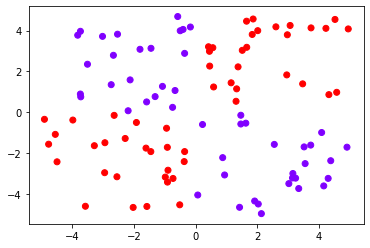

In [3]:
mpl.scatter( x[:,0], x[:,1], c=z.flatten(), cmap=cm.rainbow)
mpl.show()


Además como parte de la especificación del modelo vamos a definir unos *arrays* $Y_k$ para guardar los valores de activación de las unidades y $W_k$ para los valores de los pesos de las conexiones, incluyendo en ambos casos la dimesión adicional para los umbrales en donde sea necesario.

In [4]:
Y0 = num.zeros( (1,S[0]+1) )
Y1 = num.zeros( (1,S[1]+1) )
Y2 = num.zeros( (1,S[2]) )

In [5]:
W1 = num.random.normal( 0, 0.5, (S[0]+1, S[1]))
W2 = num.random.normal( 0, 0.5, (S[1]+1, S[2]))


Y para facilitar las operaciones también vamos a definir dos funciones adicionales que sirvan para agregar las unidades umbrales, es decir concatenar una columna con *-1* a una matriz, y quitar los umbrales, es decir eliminar la última columna de la matriz.

In [6]:
def bias_add( V):
    bias = -num.ones( (len(V),1) )
    return num.concatenate( (V,bias), axis=1)

def bias_sub( V):
    return V[:,:-1]


Cuando se trabaja con *backpropagation* generalmente hay que tener en cuenta en qué orden se toman los datos por época y cuántos datos se usan por vez para calcular las correcciones a los pesos.

En el ejemplo de regresión lineal utilizamos el conjunto de datos entero para calcular las correcciones, esto se llama *aprendizaje por lotes* (*batch*/*off-line*), y en este caso el orden de los datos es indistinto.
Pero cuando vimos cómo calcular las correcciones para el perceptrón simple usamos una instancia por vez, esto se llama *aprendizaje incremental* (*incremental*/*on-line*), y aquí recorrer las instancias en un orden aleatorio suele incrementar las chances de converger a una buena solución.

Sin embargo quizás la mejor solución es un compromiso entra ambas técnicas llama *mini-lotes* (*mini-batch*) en donde se eligen al azar porciones relativamente chicas de los datos y se los utiliza para calcular las correcciones a los pesos. Estos mini-lotes pueden verse también como una generalización, en donde el caso **1** es igual al *incremental*, y **P** igual a *lotes*.

De momento solo vamos a considerar mini-lotes de una sola instancia, es decir equivalente al *incremental*, y para esto vamos a definir una variable **B = 1**.
Para recorrer las instancias en orden aleatorio sin repetición durante una época vamos a usar *permutation*, de donde elegiremos una instancia *h*.

In [7]:
B = 1
H = num.random.permutation(P)
h = H[0]

Xh = x[h:h+B]
Zh = z[h:h+B]

Antes de empezar con el entrenamiento vamos a necesitar un *coeficiente de aprendizaje* o *learning rate* (*lr*), y una variable en donde ir acumulando el *error* por época.

In [8]:
lr = 0.1
error = 0.0

El primer paso es propagar los estímulos hacia adelante, calculando los niveles de activación de las neuronas en cada capa. En la capa de entrada tenemos que copiar el patrón de entrada, y en esta como en las capas sucesivas (excepto en la de salida), debemos agregar las unidades umbral correspondientes.

Hacer la asignación a **Yk[:]** en lugar de sencillamente a **Yk** hace que los valores resultantes de la operación en la parte derecha se copien al *array* que definimos previamente. Esta es una forma de asegurarse que al menos el resultado de la operación tiene las dimensiones que esperabamos.


In [9]:
Y0[:] = bias_add( Xh)
Y1[:] = bias_add( num.tanh( num.dot( Y0, W1)))
Y2[:] = num.tanh( num.dot( Y1, W2))

También vamos a necesitar unos *arrays* para guardar los calculos de las correcciones. Como sabemos que estos van a tener la misma dimesión que los pesos **W** podemos usar la función *zeros_like*.

In [10]:
dW1 = num.zeros_like( W1)
dW2 = num.zeros_like( W2)

Un últimos elemento que necesitamos es la derivada de la función de transferencia.
Si se está utilizando una función sigmoidea como en este caso, es posible calcular la derivada utilizando la misma función de activación.
Para el caso de $f(x)=tanh(x)$ la derivada se puede calcular como $f'(x)=1-f^2(x)$.

Con esto ya podemos calcular los *deltas* que necesitamos para las correcciones de los pesos en la capa de salida.

In [11]:
E2 = Zh-Y2
dY2 = 1-num.square(Y2)
D2 = E2*dY2

In [12]:
dW2 += lr * num.dot( Y1.T, D2)

Para calcular las correcciones de la capa oculta es la misma operación pero con dos diferencias.

- Los errores van a ser retro-propagados de la capa posterior.
- Se debe eliminar la dimensión extra en los *deltas* correspondiente a la unidad umbral.

In [13]:
E1 = num.dot( D2, W2.T)
dY1 = 1-num.square(Y1)
D1 = bias_sub( E1*dY1)

In [14]:
dW1 += lr * num.dot( Y0.T, D1)

Finalmente podemos actualizar los pesos con las correcciones y calcular la estimación del error.

Especificamente la expresión general del error es el promedio por lote de la suma de las diferencias cuadradas entre la respuesta deseada y la obtenida para todas las unidades de salida.

In [15]:
W1 += dW1
W2 += dW2

In [16]:
error += num.mean( num.sum( num.square( Zh-Y2), axis=1))